# Environment Setup

In [1]:
!pip install pylibjpeg pylibjpeg-libjpeg pydicom

In [2]:
import glob
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Data Review

In [9]:
class DataReviewer():
    def __init__(self, train_csv = "../input/rsna-breast-cancer-detection/train.csv"
                 , train_path = "../input/rsna-breast-cancer-detection/train_images"):
        self.train_csv = pd.read_csv(train_csv)
        self.train_path = train_path
        
    def show_data_for_patient(self, patient_id):
        patient_dir = os.path.join(self.train_path, str(patient_id))
        num_images = len(glob.glob(f"{patient_dir}/*"))
        print(f"Number of images for patient: {num_images}\n")
        for dcm in os.listdir(patient_dir):
            for index in range(self.train_csv.shape[0]):
                if dcm[0:-4] == str(self.train_csv["image_id"][index]):
                    row = self.train_csv[index:index+1]
            print(f"Patient ID :", row["patient_id"].item())
            # print(f"Site    ID :", row["site_id"].item())
            print(f"Image   ID :", row["image_id"].item())
            # print(f"Machine ID :", row["machine_id"].item())
            print(f"Left/Right :", row["laterality"].item())
            # print(f"View       :", row["view"].item())
            print(f"Age        :", row["age"].item())
            print(f"Cancer     :", row["cancer"].item())
            # print(f"Biopsy     :", row["biopsy"].item())
            # print(f"Invasive   :", row["invasive"].item())
            # print(f"BIRADS     :", row["BIRADS"].item())
            # print(f"Implant    :", row["implant"].item())
            # print(f"Density    :", row["density"].item())
            # print(f"Difficult Negative Case:", row["difficult_negative_case"].item())
            
            dcm_data = pydicom.dcmread(os.path.join(patient_dir, dcm))
            output_data = dcm_data.pixel_array
            if dcm_data.PhotometricInterpretation == "MONOCHROME1":
                output_data = np.amax(output_data) - output_data
            output_data = output_data * dcm_data.RescaleSlope + dcm_data.RescaleIntercept
            plt.imshow(output_data, cmap="bone")
            plt.show()
            print("\n\n")

Number of images for patient: 6

Patient ID : 10188
Image   ID : 109667135
Left/Right : L
Age        : 40.0
Cancer     : 0


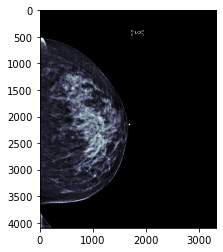




Patient ID : 10188
Image   ID : 670741863
Left/Right : R
Age        : 40.0
Cancer     : 0


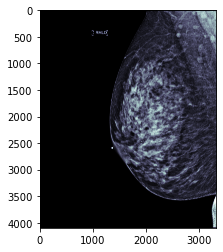




Patient ID : 10188
Image   ID : 1481469520
Left/Right : L
Age        : 40.0
Cancer     : 0


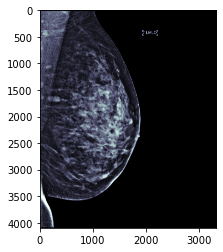




Patient ID : 10188
Image   ID : 1393196107
Left/Right : R
Age        : 40.0
Cancer     : 0


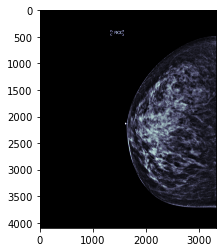




Patient ID : 10188
Image   ID : 593476281
Left/Right : R
Age        : 40.0
Cancer     : 0


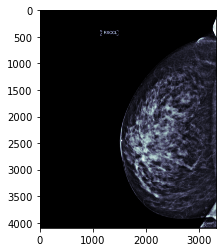




Patient ID : 10188
Image   ID : 441197449
Left/Right : L
Age        : 40.0
Cancer     : 0


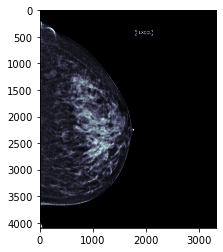

In [10]:
dr = DataReviewer()
dr.show_data_for_patient(10188)